In [34]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cbook as cbook
from matplotlib.collections import PatchCollection
import matplotlib.patches as patches
from PIL import Image
import os
import pandas as pd
import numpy as np
import random
import cv2
import csv
import os, sys, time, datetime, random
import torch
import torch.utils.data
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.autograd import Variable
import torchvision.models as models
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from tqdm import tqdm
import json
import pycocotools
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from engine import train_one_epoch, evaluate
import utils
import transforms as T

# import detectron2, etc.
import detectron2
from detectron2.config import get_cfg
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.data.datasets import register_coco_instances
from detectron2.engine import DefaultTrainer
from detectron2.engine import DefaultPredictor
from detectron2.evaluation import COCOEvaluator
from detectron2.utils.visualizer import Visualizer
from detectron2.utils.visualizer import ColorMode
from detectron2.utils.logger import setup_logger
setup_logger()

sys.path.append('../../')
from image_size import get_image_size # source: https://github.com/scardine/image_size

In [27]:
DIR_PATH = '/Users/alexdrozdz/Desktop/Studia/00. Seminarium magisterskie/'

In [28]:
def from_tsv_to_list(path):
    tsv_file = open(path)
    read_tsv = csv.reader(tsv_file, delimiter="\t")

    expected = list(read_tsv)[0]
    
    return expected

In [29]:
# train
y_train_name = from_tsv_to_list(DIR_PATH + 'Master_gonito/train/in.tsv')
y_train_annotation = from_tsv_to_list(DIR_PATH + 'Master_gonito/train/expected.tsv')

# val
y_val_name = from_tsv_to_list(DIR_PATH + 'Master_gonito/dev-0/in.tsv')
y_val_annotation = from_tsv_to_list(DIR_PATH + 'Master_gonito/dev-0/expected.tsv')

# test
y_test_name = from_tsv_to_list(DIR_PATH + 'Master_gonito/test-A/in.tsv')

In [30]:
def show_random_img_with_all_annotations(names_list, coordinates_list, path_to_photos, pages=5):
    for i in range(pages):
        random_img = random.randint(0,len(names_list))
        print(names_list[random_img])
        annotations = coordinates_list[random_img].split(';')

        with cbook.get_sample_data(path_to_photos + names_list[random_img]) as image_file:
            image = plt.imread(image_file)

        fig, ax = plt.subplots(figsize=(15, 10))
        ax.imshow(image, cmap='gray')

        for annotation in annotations:
            variables = annotation.split('/')
            coordinates = variables[1].split(',')
            x0, y0 = int(coordinates[0]), int(coordinates[1])
            x1, y1 = int(coordinates[2]), int(coordinates[3])

            if int(variables[0]) == 0:
                string_legend = str(variables[0]) + ' - photography'
                colour = 'lime'
                rect = matplotlib.patches.Rectangle(
                    (x0, y0), 
                    x1-x0, 
                    y1-y0, 
                    linewidth=1, 
                    edgecolor=colour, 
                    facecolor='none'
                )
                ax.add_patch(rect)
            elif int(variables[0]) == 1:
                string_legend = str(variables[0]) + ' - illustration'
                colour = 'orangered'
                rect = patches.Rectangle(
                    (x0, y0), 
                    x1-x0, 
                    y1-y0, 
                    linewidth=1, 
                    edgecolor=colour, 
                    facecolor='none'
                )
                ax.add_patch(rect)
            elif int(variables[0]) == 2:
                string_legend = str(variables[0]) + ' - map'
                colour = 'yellow'
                rect = patches.Rectangle(
                    (x0, y0), 
                    x1-x0, 
                    y1-y0, 
                    linewidth=1, 
                    edgecolor=colour, 
                    facecolor='none'
                )
                ax.add_patch(rect)
            elif int(variables[0]) == 3:
                string_legend = str(variables[0]) + ' - comic/caricature'
                colour = 'deepskyblue'
                rect = patches.Rectangle(
                    (x0, y0), 
                    x1-x0, 
                    y1-y0, 
                    linewidth=1, 
                    edgecolor=colour, 
                    facecolor='none'
                )
                ax.add_patch(rect)
            elif int(variables[0]) == 4:
                string_legend = str(variables[0]) + ' - political caricature'
                colour = 'violet'
                rect = patches.Rectangle(
                    (x0, y0), 
                    x1-x0, 
                    y1-y0, 
                    linewidth=1, 
                    edgecolor=colour, 
                    facecolor='none'
                )
                ax.add_patch(rect)

            ax.text(
                x0, 
                y0, 
                string_legend, 
                fontsize=8,
                backgroundcolor='black',
                color=colour
            )

        plt.show()

sn85058396_print_1918083101_0677.jpg


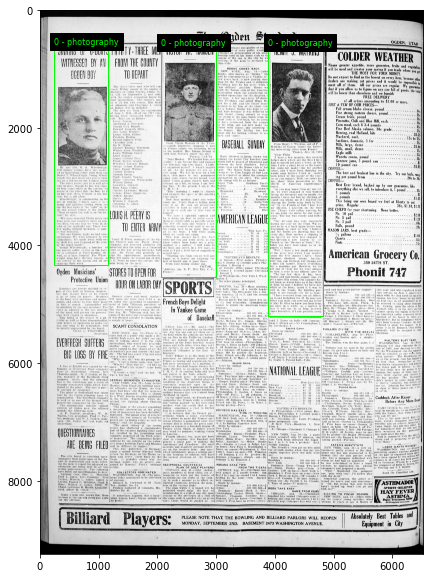

sn82016014_00295870126_1917041801_0156.jpg


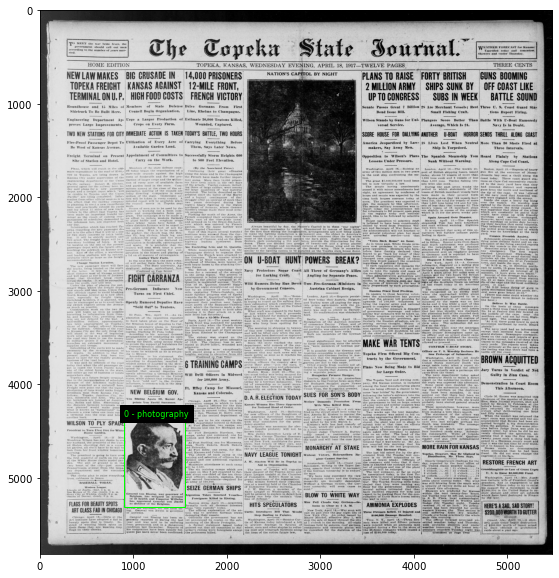

sn84026820_00271765095_1917060901_0193.jpg


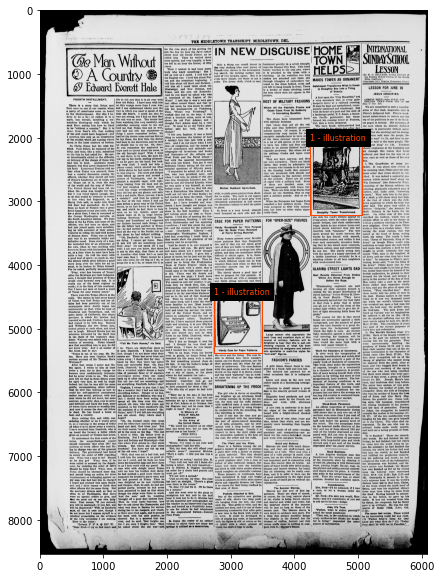

sn85058396_print_1917060401_0792.jpg


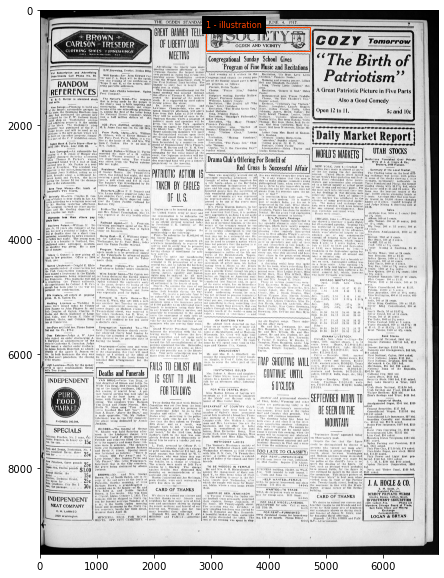

sn90061308_00294555833_1918092701_1200.jpg


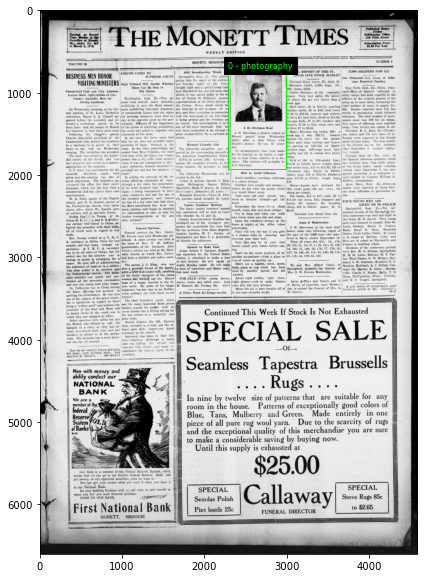

In [31]:
# some random images
show_random_img_with_all_annotations(
    y_train_name, 
    y_train_annotation, 
    DIR_PATH + 'scraped_photos_more_data/',
    pages=5
)

In [32]:
def create_dataset_annotations_dict(img_directory_path, files_list, annotations_list, output_directory_path):
    for i, file in enumerate(tqdm(files_list)):
        full_path_to_file = img_directory_path + file
        width, height = get_image_size.get_image_size(full_path_to_file)
        for annotation in annotations_list[i].split(';'):
            splitted_annotation = annotation.split('/')
            box = splitted_annotation[1].split(',')
            particular_file_dict = {
                'file_name': full_path_to_file,
                'height': height,
                'width': width,
                'image_id': file.split('.')[0],
                'annotations': {
                    'bbox': box,
                    'bbox_mode': 0,
                    'category_id': int(splitted_annotation[0])
                }
            }
                
            with open(output_directory_path+file.split('.')[0]+'.json', 'w') as fp:
                json.dump(particular_file_dict, fp, indent=4)

In [33]:
# creating dataset annotations dict
create_dataset_annotations_dict(
    DIR_PATH+'/scraped_photos_more_data/',
    y_train_name,
    y_train_annotation,
    DIR_PATH+'/scraped_photos_more_data_annotation_jsons/'
)

100%|██████████| 3657/3657 [00:02<00:00, 1428.66it/s]
